# Calibração de FSR

- fazer tabela com metodos a fazer
- gerar dados fake logaritmicos
- implementar metodos propostos no semestre passado
- comparar metodos
- O modelo autorregressivo pode ser usado para modelar o viés??

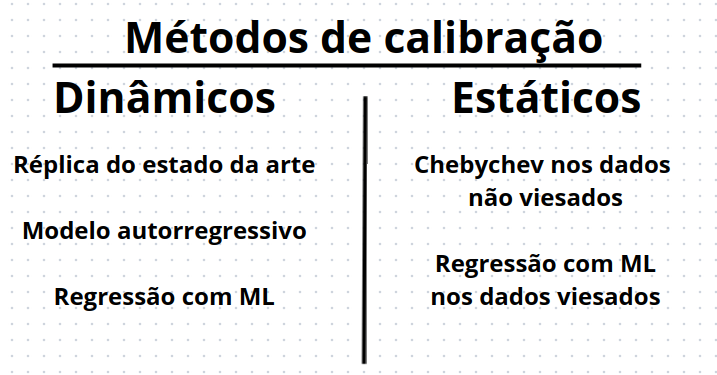

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

/home/oestefal/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Gerando dados fake

## Replicando curva do artigo base

/tmp/ipykernel_29112/720262390.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


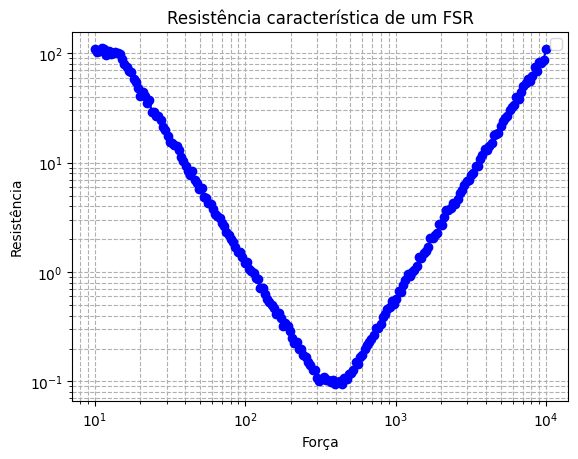

In [235]:
## versão mais proxima da realidade

# Define parameters
start = 2      # Starting exponent (log10 scale)
stop = -1       # Stopping exponent (log10 scale)
num_values = 90    # Number of values in the list
histeresis = 10

# Generate log-shaped list of floats
#log_data = np.logspace(start=start_exp, stop=stop_exp, num=num_values)
log_data = np.linspace(start=start, stop=stop, num=num_values)

# Control noise level
noise_level = 0.02  # Standard deviation of the noise

# Generate homogeneous noise (Gaussian noise with mean=0 and std=noise_level)
noise_1 = np.random.normal(loc=0, scale=noise_level, size=num_values+histeresis)
noise_2 = np.random.normal(loc=0, scale=noise_level, size=num_values+histeresis)

# Add noise to the log data

data_1 = np.concatenate((np.linspace(start, start, num=histeresis), log_data)) + noise_1
data_2 = np.concatenate((log_data, np.linspace(stop, stop, num=histeresis))) + noise_2

simulated_data_Delta = np.concatenate((data_1, data_2[::-1]))
simulated_data_Delta = 10**simulated_data_Delta

for i in range(len(simulated_data_Delta)):
    if (simulated_data_Delta[i] < 0):
        simulated_data_Delta[i] = 0


# Plot the log-shaped list
plt.plot(10**np.linspace(1, 4, 200), simulated_data_Delta, marker='o', linestyle='-', color='b')


# Customize the plot
plt.title('Resistência característica de um FSR')
plt.xlabel('Força')
plt.ylabel('Resistência')
plt.yscale('log')  # Set y-axis to log scale
plt.xscale('log') 
plt.grid(True, which="both", ls="--")  # Add a grid
plt.legend()

# Display the plot
plt.show()

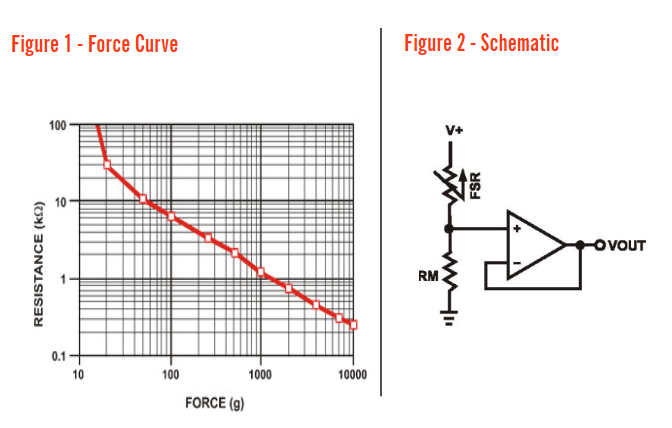

/tmp/ipykernel_29112/4055727599.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


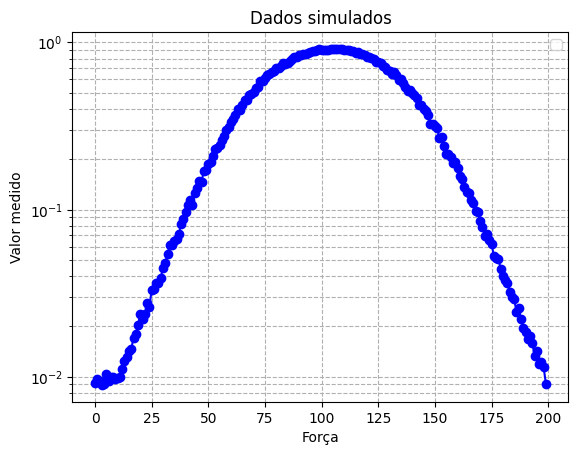

In [236]:
data = 1/(1 + simulated_data_Delta)
indexes = np.array(range(len(data)))

plt.plot(indexes, data, marker='o', linestyle='-', color='b')


# Customize the plot
plt.title('Dados simulados')
plt.xlabel('Força')
plt.ylabel('Valor medido')
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True, which="both", ls="--")  # Add a grid
plt.legend()

# Display the plot
plt.show()

Dados simulados sob hipótese de homocedasticidade e sem drift

## Confeccionando outras curvas para fim de comparação e testar generalização

Será gerada uma curva de cada tipo, junto do perfil de carga correspondente.

### Vários spikes

### Senoide

### Senoide 

# Métodos dinâmicos

COISAS PARA FAZER E DISCUTIR

- escolher o melhor intervalo e testar com diferentes curvas (varios spikes, spikes seguindo senoide, senoide, senoide composta)


## Réplica do estado da arte e discussão

Supondo que a célula de carga tem comportamento linear, podemos fazer regressões com:

In [237]:
## definindo funções de tratamento de dados e regressao plinomial

def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size  # Create weights for averaging
    return np.convolve(arr, weights, mode='same')  # Use 'valid' to avoid edge effects

def generate_sample_data(data, window_size, seed = 42):

    # Generate sample data
    np.random.seed(0)
    X1 = data
    moving_integral = moving_average(X1, window_size)
    X2 = moving_integral
    y = np.concatenate((np.array(range(int(len(X1)/2))), np.array(range(int(len(X1)/2)))[::-1]))  # Target variable with noise

    # Combine features into a single 2D array
    X = np.column_stack((X1, X2))

    return X, y
    
def polynomial_features(X, degree):
    
    n_samples, n_features = X.shape
    # Create a list to store the polynomial features
    features = []

    # Generate polynomial features
    for d in range(1, degree + 1):
        for i in range(n_features):
            for j in range(i, n_features):
                features.append((X[:, i] ** d) * (X[:, j] ** (d - i)))
                
    return np.column_stack(features)


    return X_poly



In [239]:
forecasts = pd.DataFrame(columns=np.arange(len(data)), index=np.arange(5)+1)
features = pd.DataFrame(columns=np.arange(16), index=np.arange(5)+1)

window_size = 10


for degree in np.arange(5)+1:
    
    X, y = generate_sample_data(data, window_size, seed = 42)
    
    # Create polynomial features of degree 
    X_poly = polynomial_features(X, degree=degree)
    # Add a bias (intercept) term
    X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

    # Calculate the coefficients using the normal equation
    theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y

    # Making predictions
    predictions = X_poly_biased @ theta

    forecasts.loc[degree] = predictions
    features.loc[degree] = np.concatenate((theta, np.zeros(16-len(theta))))
    

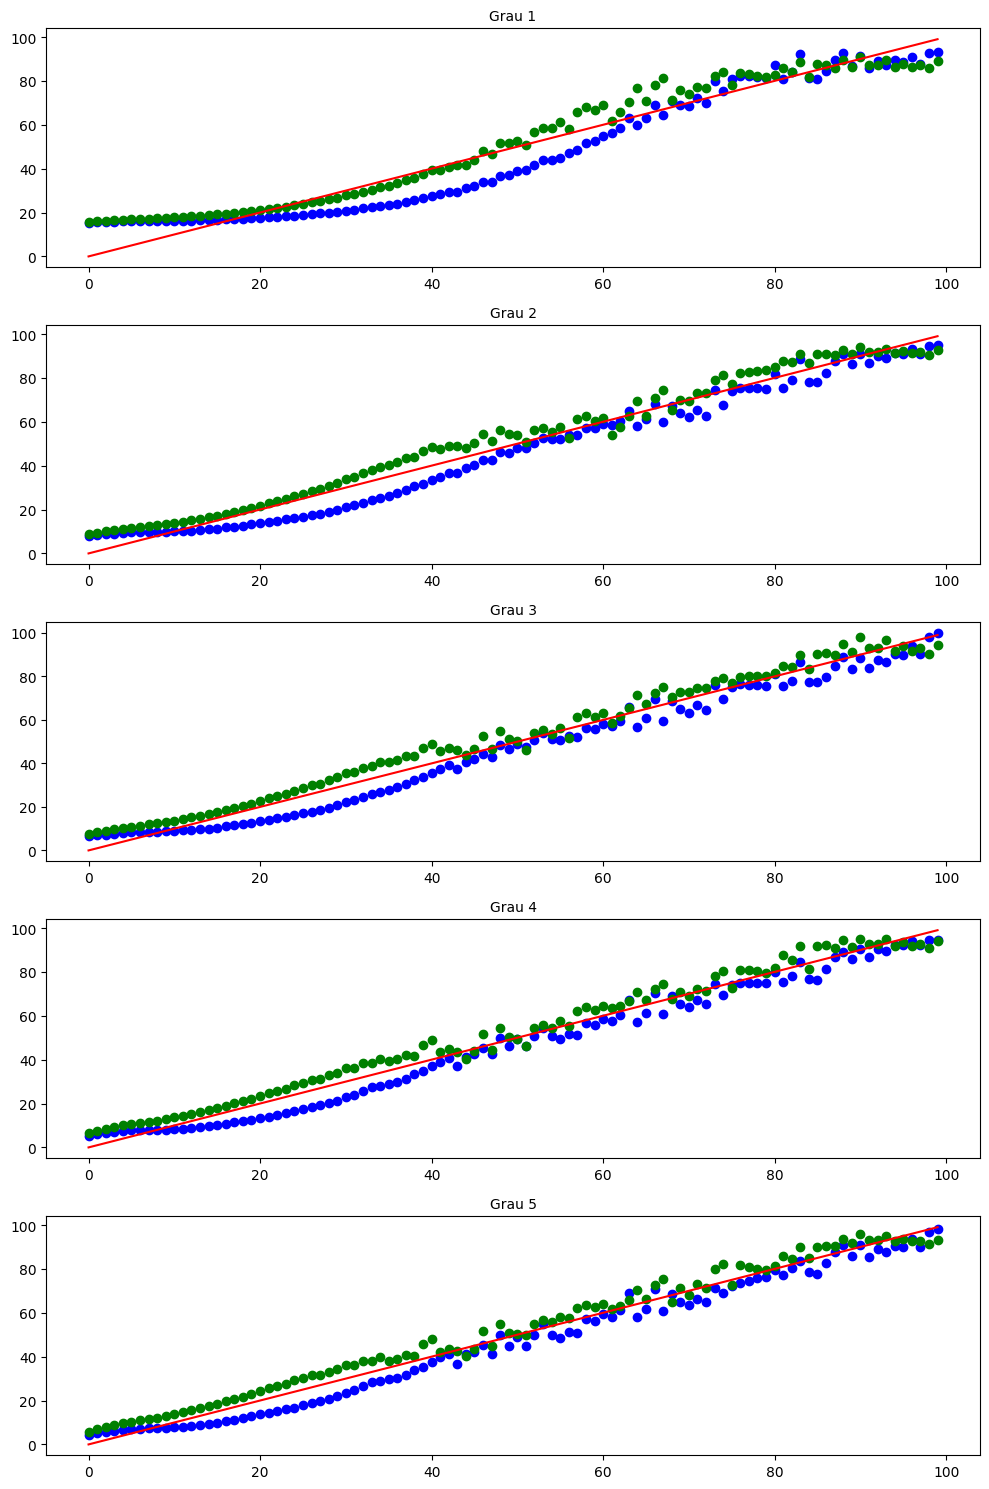

In [240]:
# Plotting the results

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(5, 1, figsize=(10, 15))


for i in forecasts.index:
        
    axs[i-1].scatter(y[:int(len(y)/2)], forecasts.loc[i][:int(forecasts.loc[i].count()/2)], color = 'blue')
    axs[i-1].scatter(y[int(len(y)/2):], forecasts.loc[i][int(forecasts.loc[i].count()/2):], color = 'green')
    axs[i-1].plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
    axs[i-1].set_title('Grau ' + str(i), fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


O dado simulado sugere que grau 4 é um valor um tanto arbitrário. Para avaliar isso, é necessário testar não usar a média móvel e testar a generalização do modelo

## Modelo de grau 4 sem média móvel

/tmp/ipykernel_29112/2974563058.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


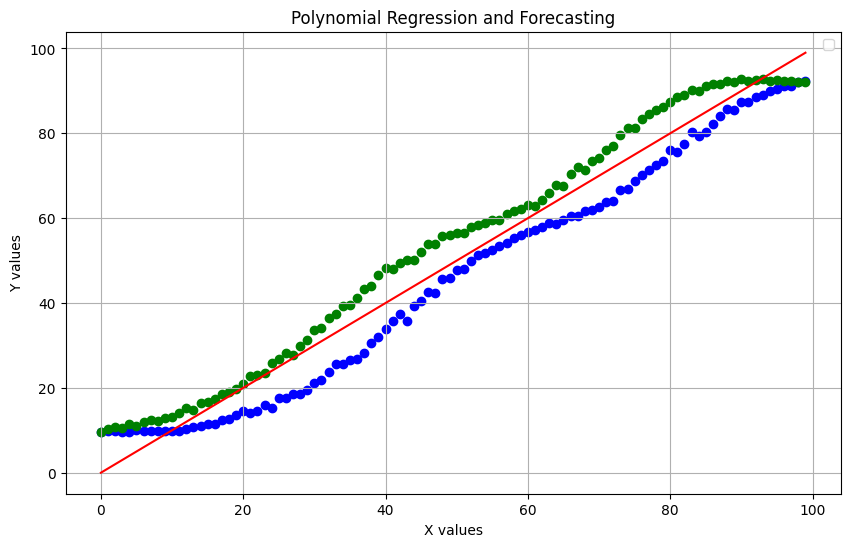

In [241]:
X, y = generate_sample_data(data, window_size = 10, seed = 42)
X = data
degree = 4

# Create polynomial features of degree 
X_poly_biased = np.column_stack([X**i for i in range(degree + 1)])

# Calculate the coefficients using the normal equation
theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y
# Making predictions
predictions = X_poly_biased @ theta

# Step 6: Plot the results
plt.figure(figsize=(10, 6))

plt.scatter(y[:int(len(y)/2)], predictions[:int(len(predictions)/2)], color = 'blue')
plt.scatter(y[int(len(y)/2):], predictions[int(len(predictions)/2):], color = 'green')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
plt.title('Grau ' + str(i), fontsize=10)

    
# Add labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression and Forecasting')
plt.legend()
plt.grid(True)
plt.show()

O modelo fica terrível sem a média móvel, então essa parte não pode ser deixada de lado.

## Tentando com outras médias móveis (grau 4)

In [242]:
forecasts = pd.DataFrame(columns=np.arange(len(data)), index=np.arange(5, 20, 5))
features = pd.DataFrame(columns=np.arange(16), index=np.arange(5, 20, 5))

degree = 4


for window_size in forecasts.index:
    
    X, y = generate_sample_data(data, window_size, seed = 42)
    
    # Create polynomial features of degree 
    X_poly = polynomial_features(X, degree=degree)
    
    # Add a bias (intercept) term
    X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

    # Calculate the coefficients using the normal equation
    theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y

    # Making predictions
    predictions = X_poly_biased @ theta

    forecasts.loc[window_size] = predictions
    features.loc[window_size] = np.concatenate((theta, np.zeros(16-len(theta))))
    

In [243]:
forecasts

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
5,5.731919,6.662338,7.594118,7.719443,7.694336,7.749714,7.850071,7.914854,7.861962,7.915357,...,12.309531,11.740686,11.152769,10.738056,10.268589,9.750874,9.288946,8.867787,7.435632,6.180755
10,5.399506,5.938081,6.382065,6.844391,7.335838,7.846664,7.853866,7.881219,7.961585,8.12244,...,12.919704,12.232726,11.72769,11.079952,10.518638,10.073996,9.150411,8.385328,7.525584,6.652
15,5.60895,5.938682,6.243487,6.550876,6.8731,7.240396,7.628407,8.04954,8.214043,8.371593,...,12.642138,12.039467,11.418833,10.544755,9.793212,9.010429,8.307912,7.703293,7.113867,6.550292


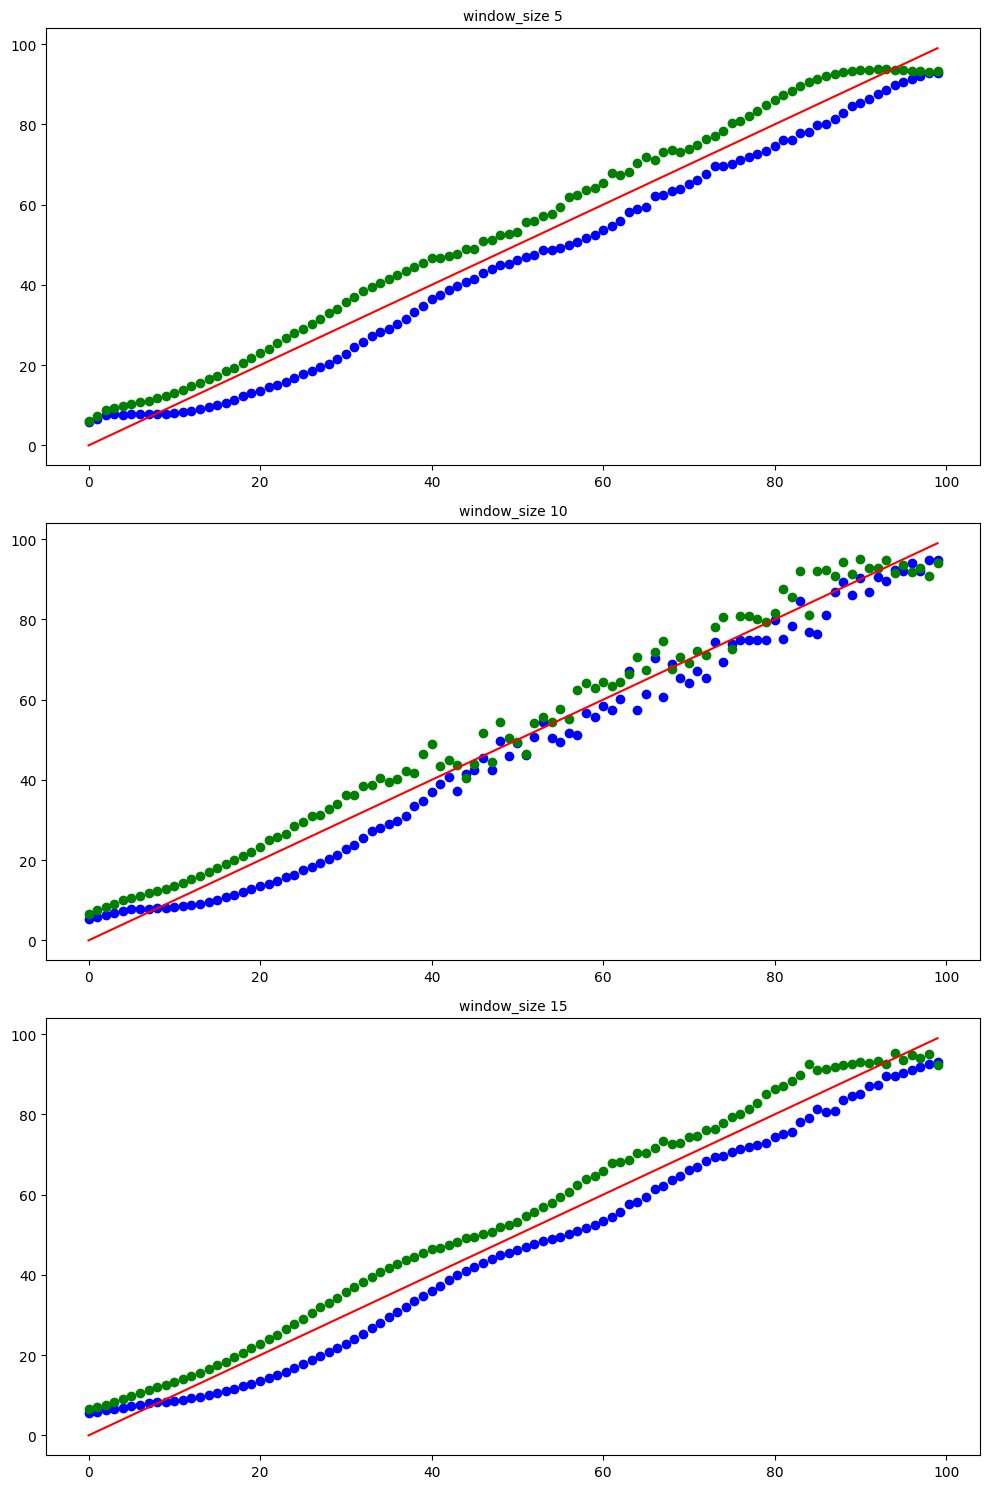

In [244]:
# Plotting the results

# Create subplots (2 rows, 3 columns)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))


for i in forecasts.index:
        
    axs[int(i/5)-1].scatter(y[:int(len(y)/2)], forecasts.loc[i][:int(forecasts.loc[i].count()/2)], color = 'blue')
    axs[int(i/5)-1].scatter(y[int(len(y)/2):], forecasts.loc[i][int(forecasts.loc[i].count()/2):], color = 'green')
    axs[int(i/5)-1].plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
    axs[int(i/5)-1].set_title('window_size ' + str(i), fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


Essa ponderação de window size como ta agora é superficial, precisa testar com outras curvas de treinamento pra fazer sentido (e, naturalmente, com dados reais).

## Testando variação com variável indicadora de subida

In [281]:
forecasts = pd.DataFrame(columns=np.arange(len(data)), index = [4])
features = pd.DataFrame(columns=np.arange(25), index=[4])

window_size = 10
degree = 4
    
X, y = generate_sample_data(data, window_size, seed = 42)
z = []
for i in range(len(y)):
    if (i<3 or len(y)-i < 3):
        z.append(2)
    else:
        prev = y[i-3] + y[i-2] + y[i-1]
        post = y[i-3] + y[i+1] + y[i-1]
        if(post-prev >= 0):
            z.append(1)
        else:
            z.append(-1)

X = np.column_stack((X, z))
# Create polynomial features of degree 
X_poly = polynomial_features(X, degree=degree)
X_poly = X_poly + np.random.rand(X_poly.shape[0], X_poly.shape[1])/1000000
# Add a bias (intercept) term
X_poly_biased = np.c_[np.ones(X_poly.shape[0]), X_poly]  # Add a column of ones for the bias term

# Calculate the coefficients using the normal equation
theta = np.linalg.solve(X_poly_biased.T @ X_poly_biased, X_poly_biased.T @ y)
#theta = np.linalg.inv(X_poly_biased.T @ X_poly_biased) @ X_poly_biased.T @ y


# Making predictions
predictions = X_poly_biased @ theta
forecasts.loc[degree] = predictions
features.loc[degree] = theta
#features.loc[degree] = np.concatenate((theta, np.zeros(25-len(theta))))



/tmp/ipykernel_29112/761050036.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


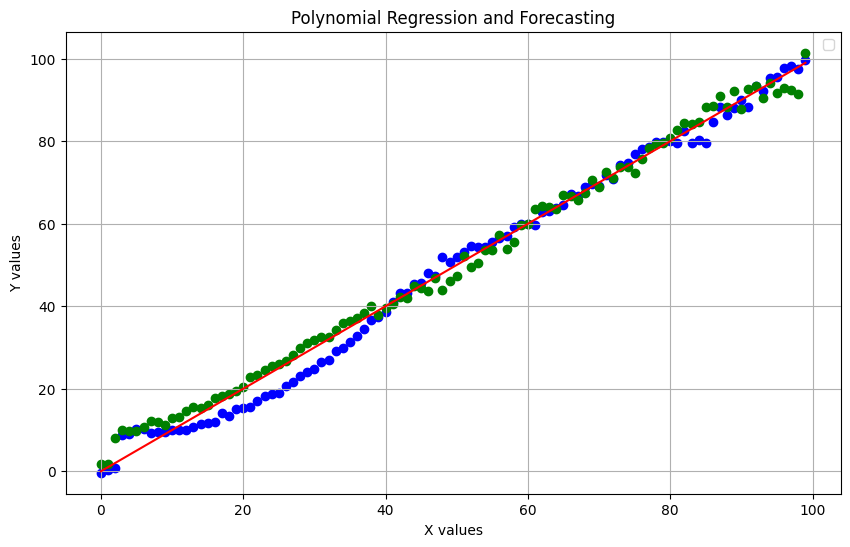

In [282]:
plt.figure(figsize=(10, 6))

plt.scatter(y[:int(len(y)/2)], predictions[:int(len(predictions)/2)], color = 'blue')
plt.scatter(y[int(len(y)/2):], predictions[int(len(predictions)/2):], color = 'green')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Line for perfect prediction
plt.title('Grau ' + str(i), fontsize=10)

    
# Add labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression and Forecasting')
plt.legend()
plt.grid(True)
plt.show()

## Testando generalização dos modelos

Fazer isso quando tiver dados de verdade

### Regresssão com ML

## Métodos estáticos